# Time series anomaly

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

pd.plotting.register_matplotlib_converters()

In [2]:
import matplotlib.dates as mdates

Parameter (aggregation frequency) - used throughout the notebook.

In [3]:
freq = '1min'

## Data preprocessing

In [4]:
base_path = './data'
df = pd.read_csv(f'{base_path}/iottraces/16-09-23/pstats.filter.csv')

Convert times from str to datetime.

In [5]:
df['time_first'] = pd.to_datetime(df['time_first'])
df['time_last'] = pd.to_datetime(df['time_last'])

Ceil by time_last (as this is the time window when we receive the flow from exporter).

In [6]:
df['time'] = df['time_last'].dt.ceil(freq)

Map devices.

In [7]:
iot_devices = {
    'd0:52:a8:00:67:5e': 'smart_things',
    '44:65:0d:56:cc:d3': 'amazon_echo',
    '70:ee:50:18:34:43': 'netatmo_welcome',
    'f4:f2:6d:93:51:f1': 'tplink_cam',
    '00:16:6c:ab:6b:88': 'samsung_cam',
    '30:8c:fb:2f:e4:b2': 'dropcam',
    '00:24:e4:11:18:a8': 'withings_baby_monitor',
    'ec:1a:59:79:f4:89': 'belkin_switch',
    '50:c7:bf:00:56:39': 'tplink_plug',
    'ec:1a:59:83:28:11': 'belkin_motion_sensor',
    '70:ee:50:03:b8:ac': 'netatmo_weather_station',
    '00:24:e4:1b:6f:96': 'withings_smart_scale',
    '18:b7:9e:02:20:44': 'triby_speaker',
    'e0:76:d0:33:bb:85': 'pixstart_photo_frame',
    '70:5a:0f:e4:9b:c0': 'hp_printer',
    '08:21:ef:3b:fc:e3': 'samsung_tablet',
    
    # not active in 16-09-23:
    
    # '00:62:6e:51:27:2e': 'insteon', 
    # '00:24:e4:20:28:c6': 'withings_sleep_sensor',
    # '74:c6:3b:29:d7:1d': 'ihome',
    # '74:6a:89:00:2e:25': 'blipcare',
    # 'd0:73:d5:01:83:08': 'lifx',
    # '30:8c:fb:b6:ea:45': 'nest_cam',
    # '18:b4:30:25:be:e4': 'nest_smoke_alarm',
}

user_devices = {
    '74:2f:68:81:69:42': 'laptop',
    'b4:ce:f6:a7:a3:c2': 'android',
    'd0:a6:37:df:a1:e1': 'iphone'
    
    # not active in 16-09-23:
    
    # '40:f3:08:ff:1e:da': 'android_phone_2',
    # 'ac:bc:32:d4:6f:2f': 'macbook',
}

devices = {}
devices.update(iot_devices)
devices.update(user_devices)

In [8]:
df = df[df['src_mac'].isin(list(devices.keys()))]

Check presence of the devices. We see that most IoT devices are present throughout the full day, in comparison to user devices, which may be present ocasionally and only at specific day-time.

In [9]:
print('IoT devices:')

for k in iot_devices:
    diff = df[df['src_mac'] == k]['time'].max() - df[df['src_mac'] == k]['time'].min()
    print(f'  {k} - {diff}')
    
print('\nUser devices:')

for k in user_devices:
    diff = df[df['src_mac'] == k]['time'].max() - df[df['src_mac'] == k]['time'].min()
    print(f'  {k} - {diff}')

IoT devices:
  d0:52:a8:00:67:5e - 0 days 04:37:00
  44:65:0d:56:cc:d3 - 0 days 23:57:00
  70:ee:50:18:34:43 - 0 days 22:38:00
  f4:f2:6d:93:51:f1 - 0 days 23:59:00
  00:16:6c:ab:6b:88 - 0 days 23:54:00
  30:8c:fb:2f:e4:b2 - 0 days 15:10:00
  00:24:e4:11:18:a8 - 0 days 23:58:00
  ec:1a:59:79:f4:89 - 0 days 23:52:00
  50:c7:bf:00:56:39 - 0 days 23:54:00
  ec:1a:59:83:28:11 - 0 days 23:55:00
  70:ee:50:03:b8:ac - 0 days 23:39:00
  00:24:e4:1b:6f:96 - 0 days 14:01:00
  18:b7:9e:02:20:44 - 0 days 23:59:00
  e0:76:d0:33:bb:85 - 0 days 23:48:00
  70:5a:0f:e4:9b:c0 - 0 days 23:57:00
  08:21:ef:3b:fc:e3 - 0 days 23:52:00

User devices:
  74:2f:68:81:69:42 - 0 days 03:11:00
  b4:ce:f6:a7:a3:c2 - 0 days 03:10:00
  d0:a6:37:df:a1:e1 - 0 days 00:27:00


## Time window aggregation

Group by time window and source mac address and aggregate four distinct features:

- sum of outgoing bytes
- sum of outgoing packets
- number of unique destination IP addresses
- number of unique destination ports

In [10]:
grouped = df.groupby(['time', 'src_mac'], as_index=False)[
    [
        'bytes',
        'packets',
        'dst_ip',
        'dst_port'
    ]
].agg(
    {
        'bytes': np.sum,
        'packets': np.sum,
        'dst_ip': lambda x: x.nunique(),
        'dst_port': lambda x: x.nunique()
    }
)

In [11]:
grouped_all = df.groupby(['time'], as_index=False)[
    [
        'bytes',
        'packets',
        'dst_ip',
        'dst_port'
    ]
].agg(
    {
        'bytes': np.sum,
        'packets': np.sum,
        'dst_ip': lambda x: x.nunique(),
        'dst_port': lambda x: x.nunique()
    }
)

Sort by time window.

In [12]:
grouped = grouped.sort_values('time')
grouped_all = grouped_all.sort_values('time')

Get time series of individual devices.

In [13]:
device_series = {}

for k, v in devices.items():
    device_series[v] = grouped[grouped['src_mac'] == k][['time', 'bytes', 'packets', 'dst_ip', 'dst_port']]
    device_series[v].set_index('time', inplace=True)
    
    # reindex so we have zero values for windows with no entry
    index = pd.date_range(min(device_series[v].index), max(device_series[v].index), freq=freq)
    device_series[v] = device_series[v].reindex(index, fill_value=0)

Similar preprocessing for time series of whole network.

In [14]:
grouped_all.set_index('time', inplace=True)

## Modelled features

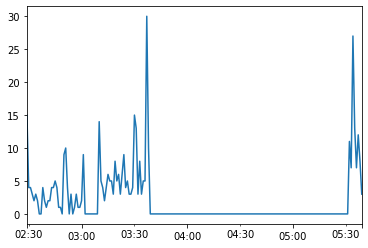

In [15]:
_ = device_series['android']['dst_ip'].plot()

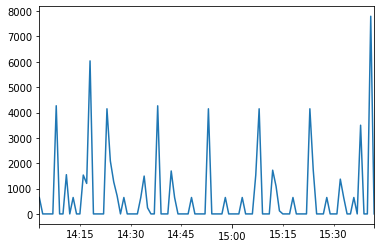

In [16]:
_ = device_series['amazon_echo']['bytes'][:100].plot()

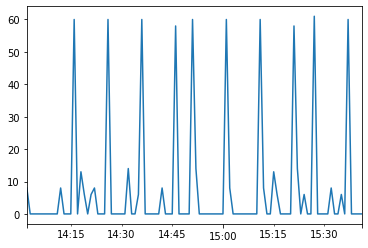

In [17]:
_ = device_series['withings_baby_monitor']['packets'][:100].plot()

## Iterative modelling of traffic.

Simulate incoming traffic.

In [18]:
def simulate_device_traffic(device, field):
    for _, row in device_series[device].iterrows():
        yield row[field]
        
def simulate_all_traffic(field):
    for _, row in grouped_all.iterrows():
        yield row[field]

In [19]:
from bota.anomaly import Welford, SimpleExpSmoothing
from tdigest import TDigest
    
w = Welford()
ses = SimpleExpSmoothing(0.1)
digest = TDigest()


traffic = {
    'val': [],
    'welford': {
        'pred': [],
        'upper': [],
        'upper_2': [],
    },
    'digest': {
        'pred': [],
        'upper': [],
        'upper_2': [],
    },
    'ses': {
        'pred': [],
        'upper': [],
        'upper_2': [],
    }
}


# simulation = simulate_device_traffic('withings_baby_monitor', 'bytes')
simulation = simulate_all_traffic('bytes')

x = next(simulation)

w.update(x)
ses.update(x)
digest.update(x)

i = 1

for x in simulation:
    
    if i > 1:
    
        traffic['val'].append(x)
    
        traffic['welford']['pred'].append(w.mean)
        traffic['welford']['upper'].append(w.mean + w.std*3)
        traffic['welford']['upper_2'].append(w.mean + w.std*5)
    
        traffic['digest']['pred'].append(digest.percentile(50))
        traffic['digest']['upper'].append(digest.percentile(99))
        traffic['digest']['upper_2'].append(digest.percentile(99.9))
    
        traffic['ses']['pred'].append(ses.pred)
        traffic['ses']['upper'].append(ses.pred + ses.std_e*3)
        traffic['ses']['upper_2'].append(ses.pred + ses.std_e*5)

    w.update(x)
    ses.update(x)
    digest.update(x)
    
    i += 1
    if i > 100:
        break

In [20]:
from bota.anomaly import SimpleExpSmoothing

traffic_ses = {
    'val': [],
    '0.1': {
        'pred': [],
        'upper': [],
    },
    '0.3': {
        'pred': [],
        'upper': [],
    },
    '0.5': {
        'pred': [],
        'upper': [],
    },
    '0.7': {
        'pred': [],
        'upper': [],
    },
    '0.9': {
        'pred': [],
        'upper': [],
    }
}

ses_1 = SimpleExpSmoothing(0.1)
ses_3 = SimpleExpSmoothing(0.3)
ses_5 = SimpleExpSmoothing(0.5)
ses_7 = SimpleExpSmoothing(0.7)
ses_9 = SimpleExpSmoothing(0.9)

simulation = simulate_all_traffic('bytes')

x = next(simulation)

ses_1.update(x)
ses_3.update(x)
ses_5.update(x)
ses_7.update(x)
ses_9.update(x)

i = 1

for x in simulation:
    
    if i > 200:
    
        traffic_ses['val'].append(x)
    
        traffic_ses['0.1']['pred'].append(ses_1.pred)
        traffic_ses['0.1']['upper'].append(ses_1.pred + ses_1.std_e*5)
        
        traffic_ses['0.3']['pred'].append(ses_3.pred)
        traffic_ses['0.3']['upper'].append(ses_3.pred + ses_3.std_e*5)
        
        traffic_ses['0.5']['pred'].append(ses_5.pred)
        traffic_ses['0.5']['upper'].append(ses_5.pred + ses_5.std_e*5)
        
        traffic_ses['0.7']['pred'].append(ses_7.pred)
        traffic_ses['0.7']['upper'].append(ses_7.pred + ses_7.std_e*5)
        
        traffic_ses['0.9']['pred'].append(ses_9.pred)
        traffic_ses['0.9']['upper'].append(ses_9.pred + ses_9.std_e*5)

    ses_1.update(x)
    ses_3.update(x)
    ses_5.update(x)
    ses_7.update(x)
    ses_9.update(x)

    i += 1
    if i > 400:
        break

In [21]:
traffic['welford']['upper_2'][0] = traffic['ses']['upper_2'][0]

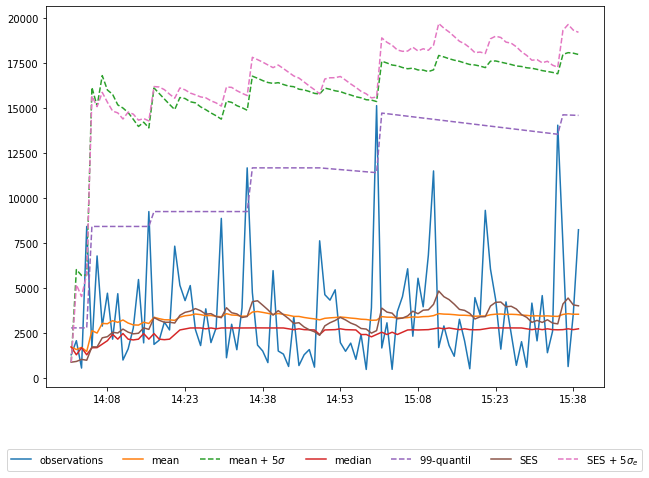

In [22]:
_, ax = plt.subplots(figsize=(10,7))

x = np.arange(0, len(traffic['val']))
x = grouped_all.iloc[0:len(traffic['val'])].index

ax.plot(x, traffic['val'], label='observations')

ax.plot(x, traffic['welford']['pred'], label='mean')
ax.plot(x, traffic['welford']['upper_2'], label='mean + $5\sigma$', linestyle='dashed')

ax.plot(x, traffic['digest']['pred'], label='median')
ax.plot(x, traffic['digest']['upper'], label='$99$-quantil', linestyle='dashed')

ax.plot(x, traffic['ses']['pred'], label='SES')
ax.plot(x, traffic['ses']['upper_2'], label='SES + $5\sigma_e$', linestyle='dashed')


ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=15))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.legend(loc=9, bbox_to_anchor=(0.5, -0.15), ncol=7)
plt.show()

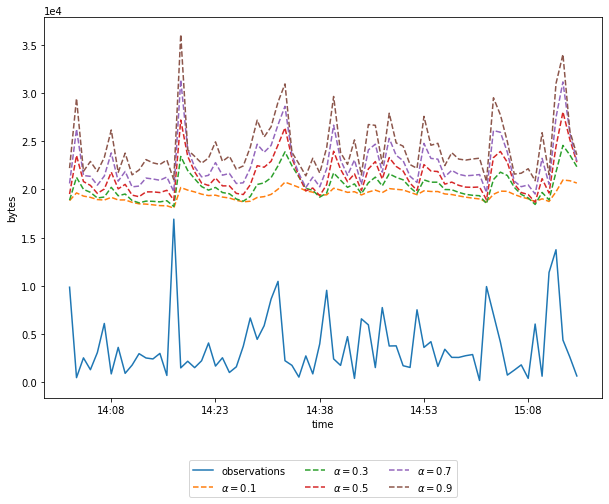

In [23]:
_, ax = plt.subplots(figsize=(10, 7))

x = grouped_all.iloc[1:75].index

ax.plot(x, traffic_ses['val'][1:75], label='observations')

ax.plot(x, traffic_ses['0.1']['upper'][1:75], label='$\\alpha=0.1$', linestyle='dashed')
ax.plot(x, traffic_ses['0.3']['upper'][1:75], label='$\\alpha=0.3$', linestyle='dashed')
ax.plot(x, traffic_ses['0.5']['upper'][1:75], label='$\\alpha=0.5$', linestyle='dashed')
ax.plot(x, traffic_ses['0.7']['upper'][1:75], label='$\\alpha=0.7$', linestyle='dashed')
ax.plot(x, traffic_ses['0.9']['upper'][1:75], label='$\\alpha=0.9$', linestyle='dashed')


ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=15))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.ticklabel_format(axis='y', style='sci', scilimits=(3,4))

plt.xlabel('time')
plt.ylabel('bytes')

plt.legend(loc=9, bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.show()